In [ ]:
import random

class WumpusWorld:
    def __init__(self, size=4, pit_ratio=0.2):
        self.size = size
        self.grid = [['' for _ in range(size)] for _ in range(size)]
        self.percepts = [[set() for _ in range(size)] for _ in range(size)]
        self.pit_ratio = pit_ratio
        self.place_elements()

    def place_elements(self):
        total_cells = self.size * self.size
        pit_count = int(total_cells * self.pit_ratio)
        self._place_random('P', pit_count, avoid={(0,0)})
        self._place_random('W', 1, avoid={(0,0)})
        self._place_random('G', 1, avoid={(0,0)})

        for i in range(self.size):
            for j in range(self.size):
                if 'P' in self.grid[i][j]:
                    self._add_adjacent_percept(i, j, 'breeze')
                if 'W' in self.grid[i][j]:
                    self._add_adjacent_percept(i, j, 'stench')
                if 'G' in self.grid[i][j]:
                    self.percepts[i][j].add('glitter')

    def _place_random(self, symbol, count, avoid=set()):
        placed = 0
        while placed < count:
            i, j = random.randint(0, self.size-1), random.randint(0, self.size-1)
            if (i, j) not in avoid and symbol not in self.grid[i][j]:
                self.grid[i][j] += symbol
                placed += 1

    def _add_adjacent_percept(self, i, j, percept):
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            ni, nj = i + dx, j + dy
            if 0 <= ni < self.size and 0 <= nj < self.size:
                self.percepts[ni][nj].add(percept)

    def print_world(self):
        for row in self.grid[::-1]:
            print(row)


In [ ]:
def generate_chromosome(length=20):
    actions = ['Move', 'TurnLeft', 'TurnRight', 'Shoot', 'Grab']
    return [random.choice(actions) for _ in range(length)]

def fitness(chromosome, env):
    score = 0
    arrow_used = False
    survived = True
    found_gold = False
    pos = [0, 0]

    for action in chromosome:
        percept = env.percepts[pos[0]][pos[1]]

        if 'breeze' in percept or 'stench' in percept:
            survived = False
            break

        if action == 'Grab' and 'glitter' in percept:
            found_gold = True
            score += 100

        elif action == 'Move':
            pos[0] = min(env.size - 1, pos[0] + 1)

        elif action == 'Shoot' and not arrow_used:
            arrow_used = True
            score += 50 if random.random() > 0.5 else -10

    score += 50 if survived else -100
    if found_gold:
        score += 50
    return score

def crossover(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def mutate(chromosome, mutation_rate=0.05):
    actions = ['Move', 'TurnLeft', 'TurnRight', 'Shoot', 'Grab']
    return [random.choice(actions) if random.random() < mutation_rate else gene for gene in chromosome]


In [ ]:
def run_simulation(env, generations=30, pop_size=50):
    population = [generate_chromosome() for _ in range(pop_size)]
    best_scores = []

    for gen in range(generations):
        scores = [fitness(ch, env) for ch in population]
        sorted_pop = [x for _, x in sorted(zip(scores, population), reverse=True)]
        best_score = max(scores)
        best_scores.append(best_score)

        next_gen = sorted_pop[:10]
        while len(next_gen) < pop_size:
            parent1, parent2 = random.choices(sorted_pop[:25], k=2)
            child = mutate(crossover(parent1, parent2))
            next_gen.append(child)

        population = next_gen
        print(f"Generation {gen+1}: Best Score = {best_score}")

    return sorted_pop[0], best_scores


In [ ]:
env = WumpusWorld(size=4)
print("Wumpus World Grid:")
env.print_world()

best_chrom, scores = run_simulation(env)

print("\nBest chromosome (action plan):")
print(best_chrom)


Wumpus World Grid:
['PG', '', '', '']
['', '', '', '']
['', '', 'W', 'P']
['', '', '', 'P']
Generation 1: Best Score = 100
Generation 2: Best Score = 100
Generation 3: Best Score = 100
Generation 4: Best Score = 100
Generation 5: Best Score = 100
Generation 6: Best Score = 100
Generation 7: Best Score = 100
Generation 8: Best Score = 100
Generation 9: Best Score = 100
Generation 10: Best Score = 100
Generation 11: Best Score = 100
Generation 12: Best Score = 100
Generation 13: Best Score = 100
Generation 14: Best Score = 100
Generation 15: Best Score = 100
Generation 16: Best Score = 100
Generation 17: Best Score = 100
Generation 18: Best Score = 100
Generation 19: Best Score = 100
Generation 20: Best Score = 100
Generation 21: Best Score = 100
Generation 22: Best Score = 100
Generation 23: Best Score = 100
Generation 24: Best Score = 100
Generation 25: Best Score = 100
Generation 26: Best Score = 100
Generation 27: Best Score = 100
Generation 28: Best Score = 100
Generation 29: Best S

In [ ]:
!pip install matplotlib


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from IPython.display import clear_output

def draw_grid(env, agent_pos):
    size = env.size
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(range(size+1))
    ax.set_yticks(range(size+1))
    ax.grid(True)
    ax.set_aspect('equal')

    for i in range(size):
        for j in range(size):
            cell_content = env.grid[i][j]
            color = 'green'

            if 'P' in cell_content:
                color = 'black'
            elif 'G' in cell_content:
                color = 'yellow'
            elif 'W' in cell_content:
                color = 'white'

            rect = patches.Rectangle((j, size-1-i), 1, 1, linewidth=1, edgecolor='gray', facecolor=color)
            ax.add_patch(rect)

            if 'W' in cell_content:
                circ = patches.Circle((j+0.5, size-1-i+0.5), 0.3, color='red')
                ax.add_patch(circ)

    ax.add_patch(patches.Circle((agent_pos[1]+0.5, size-1-agent_pos[0]+0.5), 0.3, color='lightblue'))

    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.show()

def simulate_actions_with_animation(env, chromosome):
    pos = [0, 0]
    draw_grid(env, pos)
    time.sleep(1)

    for action in chromosome:
        if action == 'Move' and pos[0] < env.size - 1:
            pos[0] += 1  # Moves down in simplified logic

        clear_output(wait=True)
        draw_grid(env, pos)
        time.sleep(0.8)

    print("Simulation complete.")


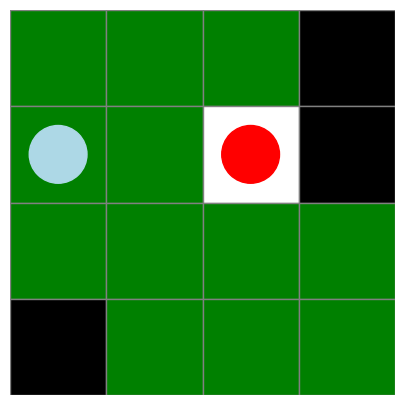

Simulation complete.


In [ ]:

simulate_actions_with_animation(env, best_chrom)


#HEAD

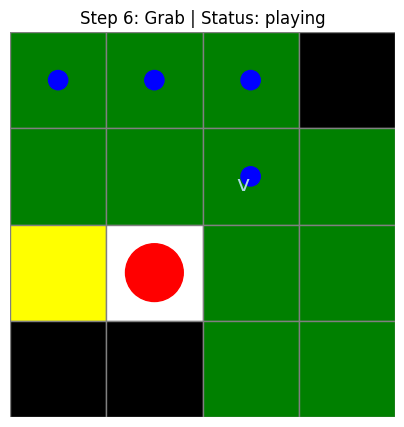


----- FINAL RESULT -----
📍 Final Position: [1, 2]
🧭 Final Direction: S
🟦 Path Taken: [(0, 0), (0, 1), (0, 2), (1, 2)]
🏹 Arrow Used: False
💰 Gold Grabbed: False
🎯 Status: SURVIVED


In [ ]:
# 📦 Setup
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from IPython.display import clear_output

# 📌 Direction logic
directions = ['N', 'E', 'S', 'W']
dx = {'N': -1, 'E': 0, 'S': 1, 'W': 0}
dy = {'N': 0, 'E': 1, 'S': 0, 'W': -1}

# 🌍 Environment Class
class WumpusWorld:
    def __init__(self, size=4, pit_ratio=0.2):
        self.size = size
        self.grid = [['' for _ in range(size)] for _ in range(size)]
        self.percepts = [[set() for _ in range(size)] for _ in range(size)]
        self.pit_ratio = pit_ratio
        self.wumpus_alive = True
        self.place_elements()

    def place_elements(self):
        total_cells = self.size * self.size
        pit_count = int(total_cells * self.pit_ratio)
        occupied = {(0, 0)}

        for i, j in self._get_random_positions(pit_count, occupied):
            self.grid[i][j] = 'P'
            occupied.add((i, j))

        i, j = self._get_random_positions(1, occupied)[0]
        self.grid[i][j] = 'W'
        self.wumpus_pos = (i, j)
        occupied.add((i, j))

        i, j = self._get_random_positions(1, occupied)[0]
        self.grid[i][j] = 'G'
        self.gold_pos = (i, j)
        occupied.add((i, j))

        for i in range(self.size):
            for j in range(self.size):
                if 'P' in self.grid[i][j]:
                    self._add_adjacent_percept(i, j, 'breeze')
                if 'W' in self.grid[i][j]:
                    self._add_adjacent_percept(i, j, 'stench')
                if 'G' in self.grid[i][j]:
                    self.percepts[i][j].add('glitter')

    def _get_random_positions(self, count, avoid):
        positions = []
        while len(positions) < count:
            i, j = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (i, j) not in avoid:
                positions.append((i, j))
                avoid.add((i, j))
        return positions

    def _add_adjacent_percept(self, i, j, percept):
        for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < self.size and 0 <= nj < self.size:
                self.percepts[ni][nj].add(percept)

    def print_world(self):
        for row in self.grid[::-1]:
            print(row)

# 🎨 Visualization
def draw_grid(env, agent_pos, path, direction, action_text, step_idx, status="playing"):
    size = env.size
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(range(size+1))
    ax.set_yticks(range(size+1))
    ax.grid(True)
    ax.set_aspect('equal')

    for i in range(size):
        for j in range(size):
            cell = env.grid[i][j]
            color = 'green'
            if 'P' in cell:
                color = 'black'
            elif 'G' in cell:
                color = 'yellow'
            elif 'W' in cell and env.wumpus_alive:
                color = 'white'
            ax.add_patch(patches.Rectangle((j, size-1-i), 1, 1, edgecolor='gray', facecolor=color))
            if 'W' in cell and env.wumpus_alive:
                ax.add_patch(patches.Circle((j+0.5, size-1-i+0.5), 0.3, color='red'))

    for (x, y) in path:
        ax.add_patch(patches.Circle((y+0.5, size-1-x+0.5), 0.1, color='blue'))

    arrow = {'N': '^', 'E': '>', 'S': 'v', 'W': '<'}[direction]
    ax.text(agent_pos[1]+0.35, size-1-agent_pos[0]+0.35, arrow, fontsize=16, color='lightblue')

    ax.set_title(f"Step {step_idx+1}: {action_text} | Status: {status}", fontsize=12)
    plt.xticks([]), plt.yticks([]), plt.box(False)
    plt.show()

# 🤖 Main Simulation
def simulate_with_animation(env, chromosome):
    pos = [0, 0]
    direction = 'E'
    path = [tuple(pos)]
    visited = set(path)
    arrow_used = False
    grabbed_gold = False
    status = 'playing'
    returning = False

    def turn_toward(current, target):
        while directions.index(current) != directions.index(target):
            yield 'TurnRight'
            current = directions[(directions.index(current) + 1) % 4]

    def return_to_start():
        return_path = []
        cx, cy = pos
        while (cx, cy) != (0, 0):
            if cx > 0 and (cx-1, cy) in visited:
                return_path.extend(turn_toward(direction, 'N'))
                return_path.append('Move')
                cx -= 1
            elif cy > 0 and (cx, cy-1) in visited:
                return_path.extend(turn_toward(direction, 'W'))
                return_path.append('Move')
                cy -= 1
            elif cy < env.size-1 and (cx, cy+1) in visited:
                return_path.extend(turn_toward(direction, 'E'))
                return_path.append('Move')
                cy += 1
            elif cx < env.size-1 and (cx+1, cy) in visited:
                return_path.extend(turn_toward(direction, 'S'))
                return_path.append('Move')
                cx += 1
            else:
                break
        return return_path

    idx = 0
    while idx < len(chromosome):
        action = chromosome[idx]
        idx += 1

        if action == 'Move':
            ni, nj = pos[0] + dx[direction], pos[1] + dy[direction]
            if 0 <= ni < env.size and 0 <= nj < env.size:
                pos = [ni, nj]
                path.append(tuple(pos))
                visited.add(tuple(pos))
            else:
                status = 'bump'

        elif action == 'TurnLeft':
            direction = directions[(directions.index(direction) - 1) % 4]
        elif action == 'TurnRight':
            direction = directions[(directions.index(direction) + 1) % 4]
        elif action == 'Shoot' and not arrow_used:
            arrow_used = True
            for k in range(1, env.size):
                ni, nj = pos[0] + dx[direction]*k, pos[1] + dy[direction]*k
                if not (0 <= ni < env.size and 0 <= nj < env.size): break
                if (ni, nj) == env.wumpus_pos:
                    env.grid[ni][nj] = ''
                    env.wumpus_alive = False
                    status = 'scream'
                    break
        elif action == 'Grab' and 'G' in env.grid[pos[0]][pos[1]]:
            grabbed_gold = True
            env.grid[pos[0]][pos[1]] = ''
            chromosome += return_to_start()
            returning = True
            continue

        if 'P' in env.grid[pos[0]][pos[1]] or ('W' in env.grid[pos[0]][pos[1]] and env.wumpus_alive):
            status = 'dead'
            draw_grid(env, pos, path, direction, action, idx, status)
            break

        clear_output(wait=True)
        draw_grid(env, pos, path, direction, action, idx, status)
        status = 'playing'
        time.sleep(0.6)

    print("\n----- FINAL RESULT -----")
    print(f"📍 Final Position: {pos}")
    print(f"🧭 Final Direction: {direction}")
    print(f"🟦 Path Taken: {path}")
    print(f"🏹 Arrow Used: {arrow_used}")
    print(f"💰 Gold Grabbed: {grabbed_gold}")
    print(f"🎯 Status: {'WON' if grabbed_gold and pos == [0, 0] else 'DEAD' if status == 'dead' else 'SURVIVED'}")

# ✅ Example Execution
env = WumpusWorld(size=4)
env.print_world()

# Sample test chromosome
sample_chrom = ['Move', 'Move', 'TurnRight', 'Move', 'Grab']
simulate_with_animation(env, sample_chrom)


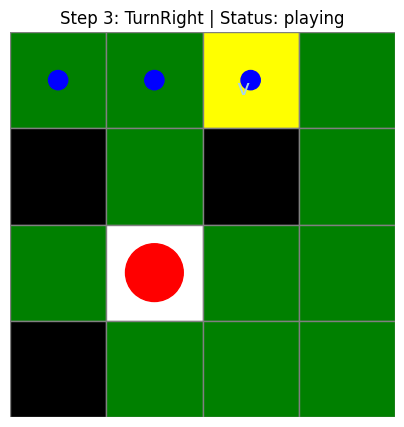

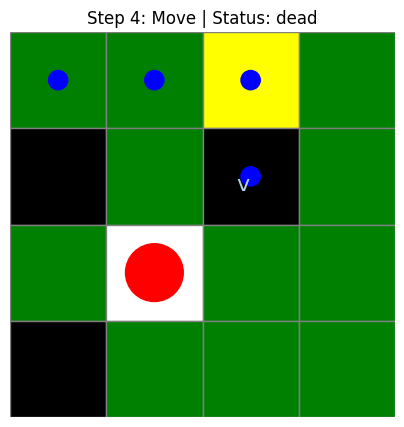


----- FINAL RESULT -----
📍 Final Position: [1, 2]
🧭 Final Direction: S
🟦 Path Taken: [(0, 0), (0, 1), (0, 2), (1, 2)]
🏹 Arrow Used: False
💰 Gold Grabbed: False
🎯 Status: DEAD


In [ ]:
env = WumpusWorld(size=4)
env.print_world()

# Full sample chromosome to test every feature
sample_chrom = ['Move', 'Move', 'TurnRight', 'Move', 'Grab', 'TurnLeft', 'Move', 'Shoot']
simulate_with_animation(env, sample_chrom)


# Main part

In [8]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from IPython.display import clear_output

# Directions
directions = ['N', 'E', 'S', 'W']
dx = {'N': -1, 'E': 0, 'S': 1, 'W': 0}
dy = {'N': 0, 'E': 1, 'S': 0, 'W': -1}


In [9]:
class WumpusWorld:
    def __init__(self, size=4, pit_ratio=0.2):
        self.size = size
        self.grid = [['' for _ in range(size)] for _ in range(size)]
        self.percepts = [[set() for _ in range(size)] for _ in range(size)]
        self.pit_ratio = pit_ratio
        self.wumpus_alive = True
        self.place_elements()

    def place_elements(self):
      total_cells = self.size * self.size
      pit_count = int(total_cells * self.pit_ratio)

      # ✅ Mark safe zones
      occupied = {(0, 0), (0, 1), (1, 0)}

      # ✅ Pits: must not go into (0,0), (0,1), or (1,0)
      for i, j in self._get_random_positions(pit_count, occupied.copy()):
          self.grid[i][j] = 'P'
          occupied.add((i, j))

      # ✅ Wumpus
      i, j = self._get_random_positions(1, occupied)[0]
      self.grid[i][j] = 'W'
      self.wumpus_pos = (i, j)
      occupied.add((i, j))

      # ✅ Gold
      i, j = self._get_random_positions(1, occupied)[0]
      self.grid[i][j] = 'G'
      self.gold_pos = (i, j)
      occupied.add((i, j))

      # ✅ Add percepts based on pits, wumpus, gold
      for i in range(self.size):
          for j in range(self.size):
              if 'P' in self.grid[i][j]:
                  self._add_adjacent_percept(i, j, 'breeze')
              if 'W' in self.grid[i][j]:
                  self._add_adjacent_percept(i, j, 'stench')
              if 'G' in self.grid[i][j]:
                  self.percepts[i][j].add('glitter')


    def _get_random_positions(self, count, avoid):
        positions = []
        while len(positions) < count:
            i, j = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (i, j) not in avoid:
                positions.append((i, j))
                avoid.add((i, j))
        return positions

    def _add_adjacent_percept(self, i, j, percept):
        for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < self.size and 0 <= nj < self.size:
                self.percepts[ni][nj].add(percept)

    def print_world(self):
        for row in self.grid[::-1]:
            print(row)


In [10]:
def draw_grid(env, agent_pos, path, direction, action_text, step_idx, status="playing", emotion=""):
    size = env.size
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(range(size+1))
    ax.set_yticks(range(size+1))
    ax.grid(True)
    ax.set_aspect('equal')

    for i in range(size):
        for j in range(size):
            cell = env.grid[i][j]
            color = 'green'
            if 'P' in cell:
                color = 'black'
            elif 'G' in cell:
                color = 'yellow'
            elif 'W' in cell and env.wumpus_alive:
                color = 'white'
            ax.add_patch(patches.Rectangle((j, size-1-i), 1, 1, edgecolor='gray', facecolor=color))
            if 'W' in cell and env.wumpus_alive:
                ax.add_patch(patches.Circle((j+0.5, size-1-i+0.5), 0.3, color='red'))

    for (x, y) in path:
        ax.add_patch(patches.Circle((y+0.5, size-1-x+0.5), 0.1, color='blue'))

    arrow = {'N': '^', 'E': '>', 'S': 'v', 'W': '<'}[direction]
    ax.text(agent_pos[1]+0.35, size-1-agent_pos[0]+0.35, arrow, fontsize=16, color='lightblue')

    ax.set_title(f"Step {step_idx+1}: {action_text} | Status: {status} | Emotion: {emotion}", fontsize=10)
    plt.xticks([]), plt.yticks([]), plt.box(False)
    plt.show()


In [11]:
def simulate_chromosome(env, chromosome, visualize=False):
    pos = [0, 0]
    direction = 'E'
    path = [tuple(pos)]
    visited = set(path)
    arrow_used = False
    grabbed_gold = False
    died = False

    for idx, action in enumerate(chromosome):
        emotion = ""

        # Emotion: bump
        ni, nj = pos[0] + dx[direction], pos[1] + dy[direction]
        if action == 'Move' and not (0 <= ni < env.size and 0 <= nj < env.size):
            emotion = "bump"

        # Emotion: percepts
        if 'breeze' in env.percepts[pos[0]][pos[1]]:
            emotion = "breeze"
        if 'stench' in env.percepts[pos[0]][pos[1]] and env.wumpus_alive:
            emotion = "stench"

        # Adjacent Wumpus Kill Logic for auto scream or Shoot
        wx, wy = env.wumpus_pos
        ax, ay = pos
        is_adj = abs(wx - ax) + abs(wy - ay) == 1
        facing_map = {'N': (-1, 0), 'S': (1, 0), 'E': (0, 1), 'W': (0, -1)}
        is_facing = is_adj and facing_map[direction] == (wx - ax, wy - ay)

        # Only allow shoot if facing Wumpus & adjacent
        if action == 'Shoot':
            if env.wumpus_alive and is_facing and not arrow_used:
                env.grid[wx][wy] = ''
                env.wumpus_alive = False
                arrow_used = True
                emotion = "scream"
            else:
                continue  # skip this shoot as it’s invalid

        # Only allow grab if on gold cell
        elif action == 'Grab':
            if 'G' in env.grid[pos[0]][pos[1]]:
                grabbed_gold = True
                env.grid[pos[0]][pos[1]] = ''
                emotion = "glitter + grab"
                if visualize:
                    clear_output(wait=True)
                    draw_grid(env, pos, path, direction, action, idx, status="won", emotion=emotion)
                    time.sleep(2)
                break  # ✅ end simulation after grabbing gold
            else:
                continue  # invalid grab, skip

        # Move
        elif action == 'Move':
            if 0 <= ni < env.size and 0 <= nj < env.size:
                pos = [ni, nj]
                path.append(tuple(pos))
                visited.add(tuple(pos))
        # Turns
        elif action == 'TurnLeft':
            direction = directions[(directions.index(direction) - 1) % 4]
        elif action == 'TurnRight':
            direction = directions[(directions.index(direction) + 1) % 4]

        # Death check
        if 'P' in env.grid[pos[0]][pos[1]] or ('W' in env.grid[pos[0]][pos[1]] and env.wumpus_alive):
            died = True
            emotion = "dead"

        if visualize:
            clear_output(wait=True)
            draw_grid(env, pos, path, direction, action, idx, status="dead" if died else "playing", emotion=emotion)
            time.sleep(2)

        if died:
            break

    # FITNESS
    fitness = 0
    if grabbed_gold: fitness += 100
    if not died: fitness += 50
    fitness += -len(chromosome) * 2
    return fitness, grabbed_gold, chromosome


In [12]:
actions = ['Move', 'TurnLeft', 'TurnRight', 'Shoot', 'Grab']

def generate_chromosome(length=30):
    return [random.choice(actions) for _ in range(length)]

def crossover(p1, p2):
    idx = random.randint(1, len(p1) - 2)
    return p1[:idx] + p2[idx:]

def mutate(chromosome, rate=0.1):
    return [random.choice(actions) if random.random() < rate else gene for gene in chromosome]

def run_ga(generations=50, pop_size=100, chrom_len=30):
    env = WumpusWorld()
    env.print_world()
    population = [generate_chromosome(chrom_len) for _ in range(pop_size)]
    best_fit = -float('inf')
    best_chrom = None

    for gen in range(generations):
        scores = []
        for chrom in population:
            copied_env = WumpusWorld()  # reinit each run
            copied_env.grid = [row.copy() for row in env.grid]
            copied_env.wumpus_alive = env.wumpus_alive
            copied_env.wumpus_pos = env.wumpus_pos
            copied_env.gold_pos = env.gold_pos

            fit, won, _ = simulate_chromosome(copied_env, chrom)
            scores.append((fit, chrom))
            if fit > best_fit:
                best_fit = fit
                best_chrom = chrom

        scores.sort(reverse=True)
        top = [chrom for _, chrom in scores[:pop_size//2]]
        population = top + [mutate(crossover(random.choice(top), random.choice(top))) for _ in range(pop_size//2)]

    print(f"\n🔥 Best Fitness: {best_fit}")
    return env, best_chrom


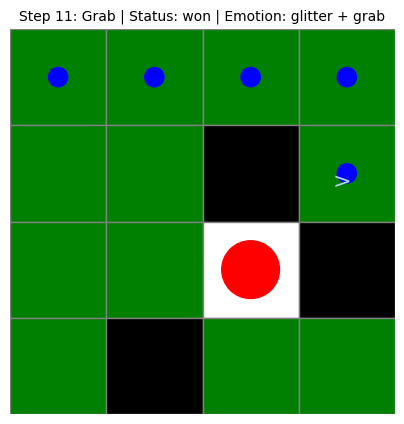

(90,
 True,
 ['Shoot',
  'Move',
  'Move',
  'Move',
  'Shoot',
  'Move',
  'TurnRight',
  'Grab',
  'Move',
  'TurnLeft',
  'Grab',
  'Grab',
  'Shoot',
  'TurnLeft',
  'Move',
  'Grab',
  'Move',
  'Shoot',
  'TurnRight',
  'TurnRight',
  'Grab',
  'TurnLeft',
  'Grab',
  'Grab',
  'TurnLeft',
  'Move',
  'TurnLeft',
  'Move',
  'Move',
  'TurnRight'])

In [14]:
env, best_chrom = run_ga(generations=60, pop_size=120, chrom_len=30)
print("\n🏆 Best Chromosome:")
print(best_chrom)

print("\n🎬 Final Simulation of Best Chromosome")
simulate_chromosome(env, best_chrom, visualize=True)


# Menu Driven

In [2]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
import time
import copy



In [3]:
directions = ['N', 'E', 'S', 'W']
dx = {'N': -1, 'E': 0, 'S': 1, 'W': 0}
dy = {'N': 0, 'E': 1, 'S': 0, 'W': -1}


In [4]:
class WumpusWorld:
    def __init__(self, size=4, pit_ratio=0.2):
        self.size = size
        self.pit_ratio = pit_ratio  # 🔧 Fix for pit_ratio error
        self.grid = [['' for _ in range(size)] for _ in range(size)]
        self.percepts = [[set() for _ in range(size)] for _ in range(size)]
        self.revealed = [[False for _ in range(size)] for _ in range(size)]
        self.wumpus_alive = True
        self.place_elements()

    def place_elements(self):
        total_cells = self.size * self.size
        pit_count = int(total_cells * self.pit_ratio)
        occupied = {(0, 0), (0, 1), (1, 0)}  # safe cells

        for i, j in self._get_random_positions(pit_count, occupied.copy()):
            self.grid[i][j] = 'P'
            occupied.add((i, j))

        i, j = self._get_random_positions(1, occupied)[0]
        self.grid[i][j] = 'W'
        self.wumpus_pos = (i, j)
        occupied.add((i, j))

        i, j = self._get_random_positions(1, occupied)[0]
        self.grid[i][j] = 'G'
        self.gold_pos = (i, j)
        occupied.add((i, j))

        for i in range(self.size):
            for j in range(self.size):
                if 'P' in self.grid[i][j]:
                    self._add_adjacent_percept(i, j, 'breeze')
                if 'W' in self.grid[i][j]:
                    self._add_adjacent_percept(i, j, 'stench')
                if 'G' in self.grid[i][j]:
                    self.percepts[i][j].add('glitter')

    def _get_random_positions(self, count, avoid):
        positions = []
        while len(positions) < count:
            i, j = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (i, j) not in avoid:
                positions.append((i, j))
                avoid.add((i, j))
        return positions

    def _add_adjacent_percept(self, i, j, percept):
        for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < self.size and 0 <= nj < self.size:
                self.percepts[ni][nj].add(percept)


In [5]:
def draw_grid(env, agent_pos, direction, step_text="", status="playing", emotion=""):
    size = env.size
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(range(size+1))
    ax.set_yticks(range(size+1))
    ax.grid(True)
    ax.set_aspect('equal')

    for i in range(size):
        for j in range(size):
            visible = env.revealed[i][j]
            color = 'green'
            if visible:
                if 'P' in env.grid[i][j]:
                    color = 'black'
                elif 'G' in env.grid[i][j]:
                    color = 'yellow'
                elif 'W' in env.grid[i][j]:
                    color = 'white'
            ax.add_patch(patches.Rectangle((j, size-1-i), 1, 1, edgecolor='gray', facecolor=color))
            if visible and 'W' in env.grid[i][j]:
                ax.add_patch(patches.Circle((j+0.5, size-1-i+0.5), 0.3, color='red'))

    ax.add_patch(patches.Circle((agent_pos[1]+0.5, size-1-agent_pos[0]+0.5), 0.2, color='blue'))
    arrow = {'N': '^', 'E': '>', 'S': 'v', 'W': '<'}[direction]
    ax.text(agent_pos[1]+0.35, size-1-agent_pos[0]+0.35, arrow, fontsize=16, color='lightblue')

    ax.set_title(f"Step: {step_text} | Status: {status} | Emotion: {emotion}", fontsize=10)
    plt.xticks([]), plt.yticks([]), plt.box(False)
    plt.show()


In [6]:
def play_wumpus_interactive(saved_env=None):
    if saved_env:
        env = copy.deepcopy(saved_env)
    else:
        env = WumpusWorld()

    saved_copy = copy.deepcopy(env)
    pos = [0, 0]
    direction = 'E'
    status = "playing"
    emotion = ""
    step_text = "start"
    env.revealed[pos[0]][pos[1]] = True

    while True:
        clear_output(wait=True)

        percepts = env.percepts[pos[0]][pos[1]]
        if 'breeze' in percepts:
            emotion = "breeze"
        if 'stench' in percepts and env.wumpus_alive:
            emotion = "stench"
        if 'glitter' in percepts:
            emotion = "glitter"


        if status == "dead":
            for i in range(env.size):
                for j in range(env.size):
                    env.revealed[i][j] = True

        draw_grid(env, pos, direction, step_text, status, emotion)
        time.sleep(2)

        if status != "playing":
            print("\n💀 GAME OVER! Press R to Retry, N for New Game")
            choice = input(">> ").strip().upper()
            if choice == "R":
                return play_wumpus_interactive(saved_env=saved_copy)
            elif choice == "N":
                return play_wumpus_interactive()
            else:
                continue

        key = input("Your Move [W=Forward, A=Left, D=Right, S=Shoot]:\n ").strip().upper()
        step_text = ""

        if key == "W":
            ni, nj = pos[0] + dx[direction], pos[1] + dy[direction]
            if 0 <= ni < env.size and 0 <= nj < env.size:
                pos = [ni, nj]
                env.revealed[ni][nj] = True
                step_text = "move"
                if 'P' in env.grid[ni][nj]:
                    status = "dead"
                    step_text = "pit"
                elif 'W' in env.grid[ni][nj] and env.wumpus_alive:
                    status = "dead"
                    step_text = "wumpus"
                elif 'G' in env.grid[ni][nj]:
                    status = "won"
                    step_text = "gold"
                    emotion = "glitter+grab"
            else:
                emotion = "bump"
                step_text = "wall"
        elif key == "A":
            direction = directions[(directions.index(direction) - 1) % 4]
            step_text = "turn left"
        elif key == "D":
            direction = directions[(directions.index(direction) + 1) % 4]
            step_text = "turn right"
        elif key == "S":
            wx, wy = env.wumpus_pos
            ax, ay = pos
            is_adj = abs(wx - ax) + abs(wy - ay) == 1
            facing_map = {'N': (-1, 0), 'S': (1, 0), 'E': (0, 1), 'W': (0, -1)}
            is_facing = is_adj and facing_map[direction] == (wx - ax, wy - ay)
            if is_facing and env.wumpus_alive:
                env.grid[wx][wy] = ''
                env.wumpus_alive = False
                emotion = "scream"
                env.revealed[wx][wy] = True
                step_text = "shoot (kill)"
            else:
                step_text = "shoot (miss)"


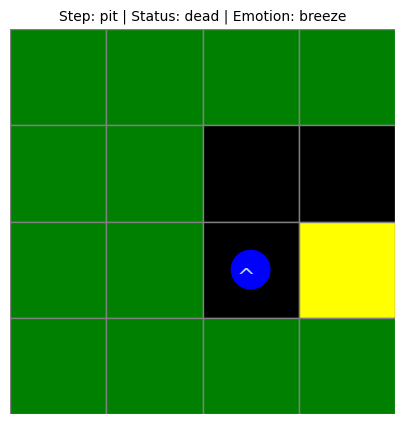


💀 GAME OVER! Press R to Retry, N for New Game


KeyboardInterrupt: Interrupted by user

In [7]:
play_wumpus_interactive()
